In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools

In [ ]:
data = []
names = ['/content/1.txt','/content/2.txt']
for elem in names:
  with open(elem) as f:
    float_data = list(map(float, f.readlines()))
    data.append(float_data)


In [ ]:
def weighted(window_size):
  half_window = window_size // 2  # определяем длину половины окна
  indices = np.arange(-half_window, half_window + 1)  # индексы от -m до m
  weights = np.exp(-0.3 * np.abs(indices))  # вычисляем веса
  weights /= np.sum(weights)  # нормализуем веса, чтобы их сумма была равна 1
  return weights

def non_weighted(window_size):
  half_window = window_size // 2  # определяем длину половины окна
  indices = np.arange(-half_window, half_window + 1)  # индексы от -m до m
  weights = 1.0 * np.abs(indices)  # вычисляем веса
  weights /= np.sum(weights)  # нормализуем веса, чтобы их сумма была равна 1
  return weights

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class MovingAverage:
    def __init__(self, data = None,window_size = 3,calculate_weights = weighted,to_plot = False):
        self.data = data
        self.window_size = window_size # длины окон
        self.calculate_weights = calculate_weights
        self.epsilon = 0.3  # значение epsilon
        self.get_res()
        if to_plot:
          self.calculate_and_plot()

    def calculate_moving_average(self):
        half_window = self.window_size // 2
        padded_data = np.pad(self.data, (half_window, half_window), mode='edge')  # Дополняем данные для границ
        weights = self.calculate_weights(self.window_size)  # Получаем веса для текущего окна
        moving_avg = []  # Список для хранения скользящего среднего
        for i in range(len(self.data)):
            window = padded_data[i:i + self.window_size]  # Получаем данные в текущем окне
            weighted_avg = np.dot(window, weights)  # Вычисляем взвешенное среднее
            moving_avg.append(weighted_avg)
        return moving_avg


    def get_res(self):
        self.moving_avg = self.calculate_moving_average()
        self.residuals = [self.data[i] - self.moving_avg[i] for i in range(min(len(self.data), len(self.moving_avg)))]


    def calculate_and_plot(self):
        plt.figure(figsize=(12, 8))
        plt.plot(range(len(self.data)), self.moving_avg, label=f"Window size: {self.window_size}")
        # Добавляем оригинальные данные на график
        self.residuals = [self.data[i] - self.moving_avg[i] for i in range(min(len(self.data), len(self.moving_avg)))]
        plt.plot(self.data, label='Original Data', linestyle='--', color='gray')
        # Настройки графика
        plt.title("Moving Averages with Different Window Sizes and Weights")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()



In [ ]:
class ExponentialMovingAverage:
    def __init__(self, data, alpha=0.5, to_plot = False):
        self.data = data
        self.alpha = alpha
        self.ema_values = self.calculate_ema()
        self.residuals = [self.data[i] - self.ema_values[i] for i in range(len(self.data))]
        if to_plot:
          self.plot_ema()

    def calculate_ema(self):
        ema_values = [self.data[0]]
        for t in range(1, len(self.data)):
            ema_t = self.alpha * self.data[t] + (1 - self.alpha) * ema_values[t - 1]
            ema_values.append(ema_t)
        return ema_values

    def plot_ema(self):
        plt.figure(figsize=(10, 6))
        # График исходных данных
        plt.plot(self.data, label='Original Data', linestyle='--', color='gray')
        # График EMA
        plt.plot(self.ema_values, label=f'EMA (alpha={self.alpha})', color='blue')
        # Настройки графика
        plt.title("Exponential Moving Average (EMA)")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt

class DoubleExponentialMovingAverage:
    def __init__(self, data, alpha_gamma = (0.5,0.5), to_plot = False):
        self.data = data
        self.alpha, self.gamma = alpha_gamma  # Коэффициент для сглаживания ряда
        self.smooth_values, self.trend_values = self.calculate_dema()
        self.residuals = [self.data[i] - self.smooth_values[i] for i in range(len(self.data))]
        if to_plot:
          self.plot_dema()


    def calculate_dema(self):
        n = len(self.data)
        smooth_values = [self.data[0]]  # Начальное сглаженное значение
        trend_values = [self.data[1] - self.data[0]]  # Начальный тренд

        for t in range(1, n):
            # Сглаживаем ряд
            smooth_t = (self.alpha * self.data[t]) + ((1 - self.alpha) * (smooth_values[t - 1] + trend_values[t - 1]))
            smooth_values.append(smooth_t)
            # Сглаживаем тренд
            trend_t = (self.gamma * (smooth_values[t] - smooth_values[t - 1])) + ((1 - self.gamma) * trend_values[t - 1])
            trend_values.append(trend_t)

        return smooth_values, trend_values

    def plot_dema(self):
        plt.figure(figsize=(10, 6))

        plt.plot(self.data, label='Original Data', linestyle='--', color='gray')
        plt.plot(self.smooth_values, label=f'DEMA Smoothed (alpha={self.alpha}, gamma={self.gamma})', color='blue')
        plt.plot(self.trend_values, label='Trend', linestyle='--', color='red')

        plt.title("Double Exponential Moving Average (DEMA)")
        plt.xlabel("Index")
        plt.ylabel("Value")
        plt.legend()
        plt.grid(True)
        plt.show()



In [ ]:
class Ljung_Box:
    def __init__(self, data, lag = 5):
        self.data = data
        self.lag = lag
        self.len = len(data)
        self.calculate_r_top(self.lag)
        self.calculate_r_bottom(self.lag)
        self.calculate_q()

    def calculate_r_top(self, k):
        self.top_1 = self.len - k
        self.top_1 *= sum([self.data[i] * self.data[i + k] for i in range(self.len - k)])
        return self.top_1 - sum([self.data[i] for i in range(self.len - k)]) * sum([self.data[i + k] for i in range(self.len - k)])

    def calculate_r_bottom(self, k):
        self.bottom_1 = ((self.len - k) * sum([self.data[i] ** 2 for i in range(self.len - k)]) - sum([self.data[i] for i in range(self.len - k)]) ** 2) ** 0.5
        return self.bottom_1 - ((self.len - k) * sum([self.data[i + k] ** 2 for i in range(self.len - k)]) - sum([self.data[i + k] for i in range(self.len - k)]) ** 2) ** 0.5

    def calculate_q(self):
        self.q = self.len * (self.len + 2) * sum([self.calculate_r_top(k) / self.calculate_r_bottom(k) for k in range(1, self.lag + 1)])


In [ ]:
class Choose_best:
  def __init__(self):
    self.m = [3,5,7,9]
    self.data = data
    self.alpha = [i/10 for i in range(1,10)]
    self.gamma = [i/10 for i in range(1,10)]
    self.res = {}
    self.models = {'Non_Weighted': MovingAverage,'Weighted': MovingAverage ,'Ema': ExponentialMovingAverage,'DEMA': DoubleExponentialMovingAverage}
    self.best_models = {}
    self.smoothings = {}
    self.calculate()
    self.choose_best()

  def calculate(self):
    for elem in self.models.keys():
      if elem == 'Non_Weighted':
        self.res[elem] = {}
        for elem_1 in self.m:
          Trial = MovingAverage(data[0],elem_1,non_weighted)
          self.res[elem][elem_1] = Ljung_Box(Trial.residuals,5).q

      if elem == 'Weighted':
        self.res[elem] = {}
        for elem_1 in self.m:
          Trial = MovingAverage(data[0],elem_1,weighted)
          self.res[elem][elem_1] = Ljung_Box(Trial.residuals,5).q

      if elem == 'Ema':
        self.res[elem] = {}
        for elem_1 in self.alpha:
          Trial = ExponentialMovingAverage(data[0],elem_1)
          self.res[elem][elem_1] =  Ljung_Box(Trial.residuals,5).q

      if elem == 'DEMA':
        self.res[elem] = {}
        for elem_1 in self.alpha:
          for elem_2 in self.gamma:
            Trial = DoubleExponentialMovingAverage(data[0],(elem_1,elem_2))
            self.res[elem][(elem_1,elem_2)] = Ljung_Box(Trial.residuals,5).q

  def choose_best(self):
    for elem in self.models.keys():
      self.best_models[elem] = max(self.res[elem], key = self.res[elem].get)
    print(self.best_models)
    self.plot_best()

  def plot_best(self):
    for elem in self.best_models.keys():
      if elem  in ['Ema','DEMA']:
        print(elem,type(self.best_models[elem]))
        Example = self.models[elem](data[0],self.best_models[elem],True)
      elif elem == 'Weighted':
        Example = self.models[elem](data[0],self.best_models[elem],weighted,True)
      else:
        Example = self.models[elem](data[0],self.best_models[elem],non_weighted,True)
      print(len(Example.residuals))
      self.smoothings[elem] = Example


{'Non_Weighted': 9, 'Weighted': 9, 'Ema': 0.7, 'DEMA': (0.4, 0.8)}


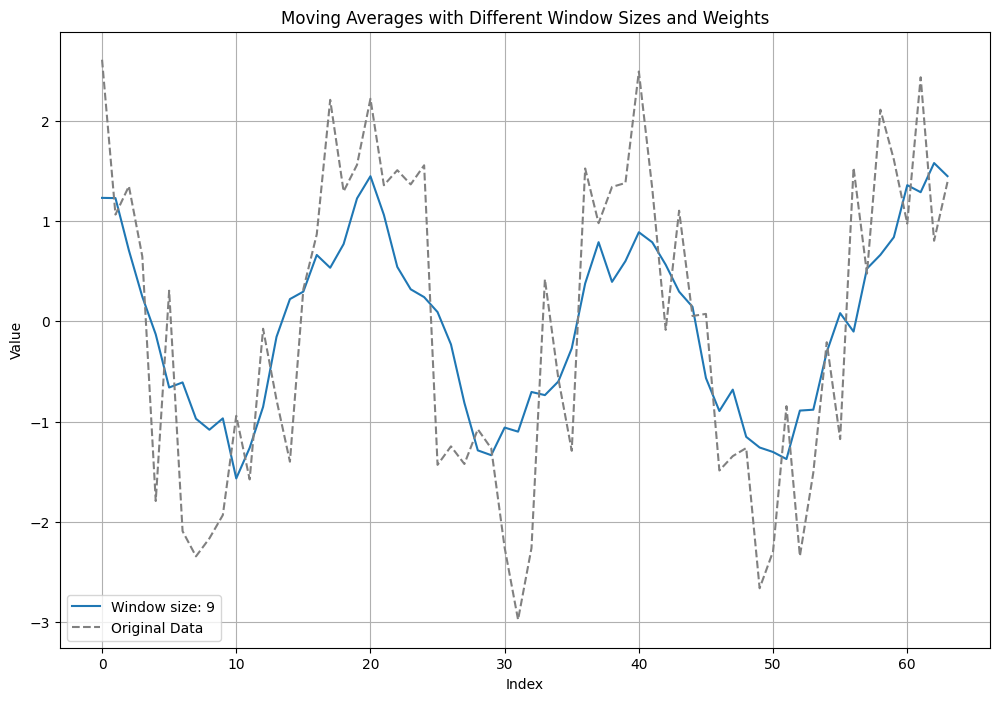

64


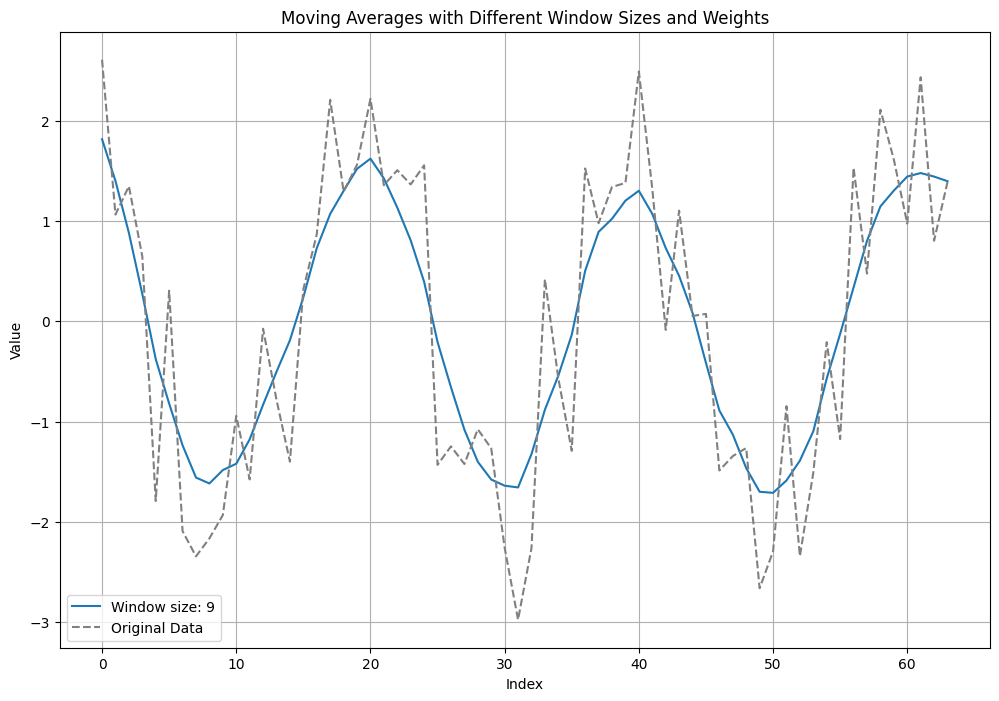

64
Ema <class 'float'>
64
DEMA <class 'tuple'>


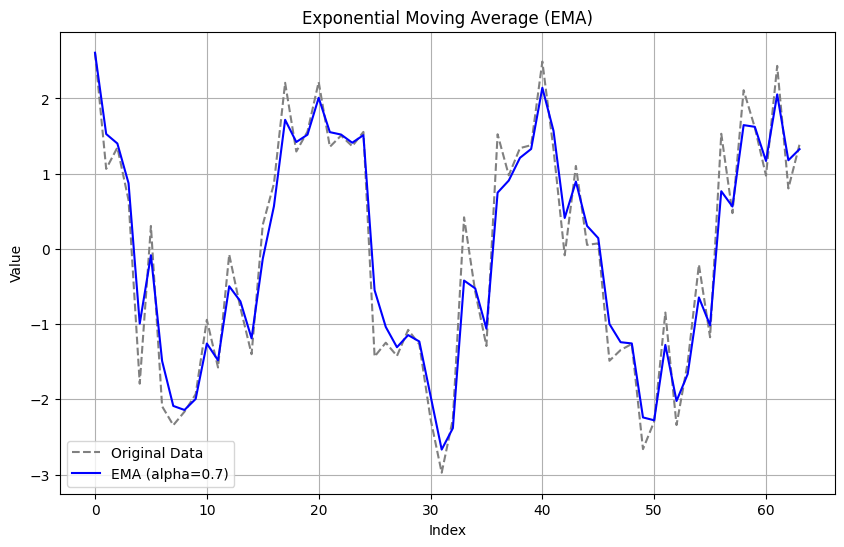

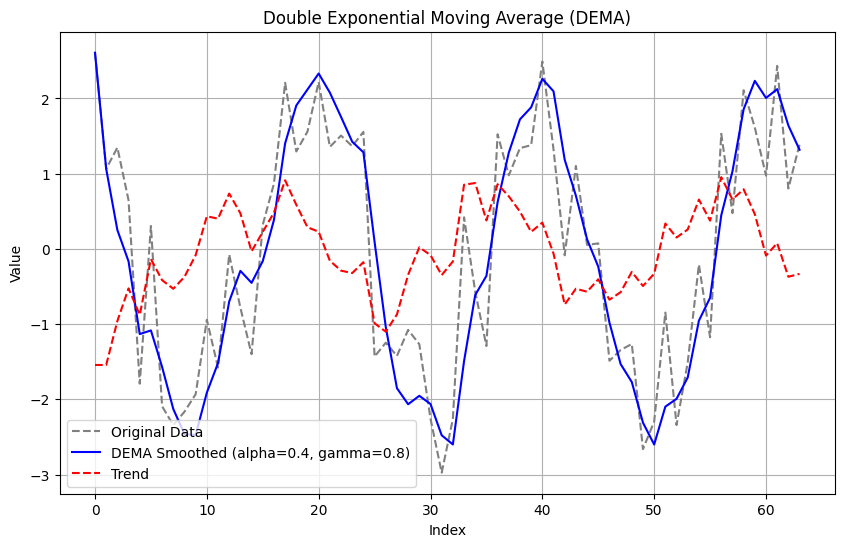

64


{'Non_Weighted': {3: -10097089.307489408,
  5: -73791466.78401572,
  7: -4632285.380075901,
  9: 8177482.518256266},
 'Weighted': {3: -6028367.096939146,
  5: -29571344.721001673,
  7: -22015272.296209995,
  9: -4523046.629172943},
 'Ema': {0.1: -72157128.93596333,
  0.2: -188235540.59002906,
  0.3: -601128501.2286431,
  0.4: -743424631.354665,
  0.5: -542251860.6091335,
  0.6: -173869196.79275963,
  0.7: 19544847.418396655,
  0.8: 17784960.28157161,
  0.9: -1191425.0517117109},
 'DEMA': {(0.1, 0.1): 1210970183.3939989,
  (0.1, 0.2): 2790633448.936312,
  (0.1, 0.3): 1539616326.3692229,
  (0.1, 0.4): 1861412224.3047106,
  (0.1, 0.5): 2737897329.744575,
  (0.1, 0.6): -10667447720.105133,
  (0.1, 0.7): -476351555.06272244,
  (0.1, 0.8): -129767108.34180231,
  (0.1, 0.9): -60153290.00243349,
  (0.2, 0.1): -7949554592.673278,
  (0.2, 0.2): -1019351191.7609444,
  (0.2, 0.3): -313268538.0057362,
  (0.2, 0.4): -77888211.47590666,
  (0.2, 0.5): -39626520.05952523,
  (0.2, 0.6): -30871608.140125

In [ ]:
Choose_best().res

In [ ]:
class Darwin_Uotson:
  def __init__(self,data):
    self.data = data[0]
    self.best = Choose_best()
    self.dL, self.dU = 1.41,1.47
    self.residuals = {}
    self.d = {}
    self.d_tilda = {}
    self.get_residuals()
    self.calculate_darwin()

  def get_residuals(self):
    for elem in self.best.smoothings.keys():
      self.residuals[elem] = self.best.smoothings[elem].residuals

  def calculate_darwin(self):
    for elem in self.best.smoothings.keys():
      res_cur = self.residuals[elem]
      # self.d[elem] = sum([(res_cur[i] - res_cur[i-1]) ** 2] for i in range(1,len(self.residuals)))
      sqr_diff = [(res_cur[i] - res_cur[i-1]) ** 2 for i in range(1,len(self.residuals))]
      self.d[elem] = sum(sqr_diff)
      print(self.d)
      print(self.dL,self.dU)
    self.interpret()

  def interpret(self):
    for elem in self.d.keys():
      self.d_tilda[elem] = self.d[elem] if 0<=self.d[elem]<=2 else 4 - self.d[elem]
      print(f'Для алгоритма сглаживания {elem}')
      if self.d_tilda[elem] < self.dL:
         print("Наличествует положительная автокорреляция первого порядка")
      elif self.d_tilda[elem] > self.dU:
        print("Наличествует отрицательная автокорреляция первого порядка")
      else:
        print("Нет оснований для вывода о наличии автокорреляции первого порядка")

{'Non_Weighted': 9, 'Weighted': 9, 'Ema': 0.7, 'DEMA': (0.4, 0.8)}


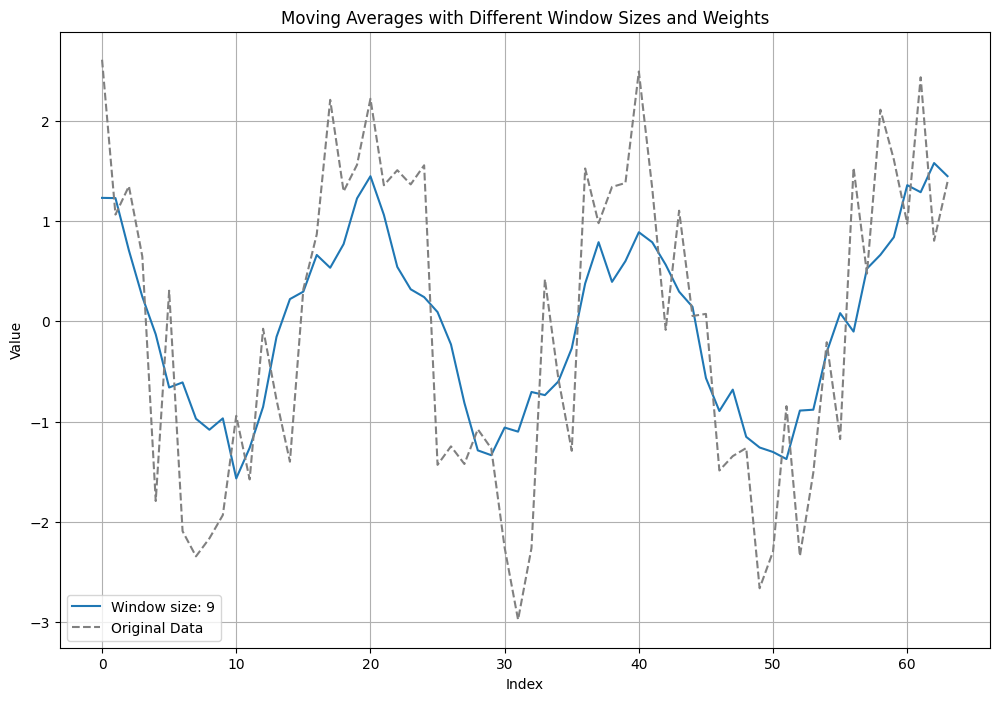

64


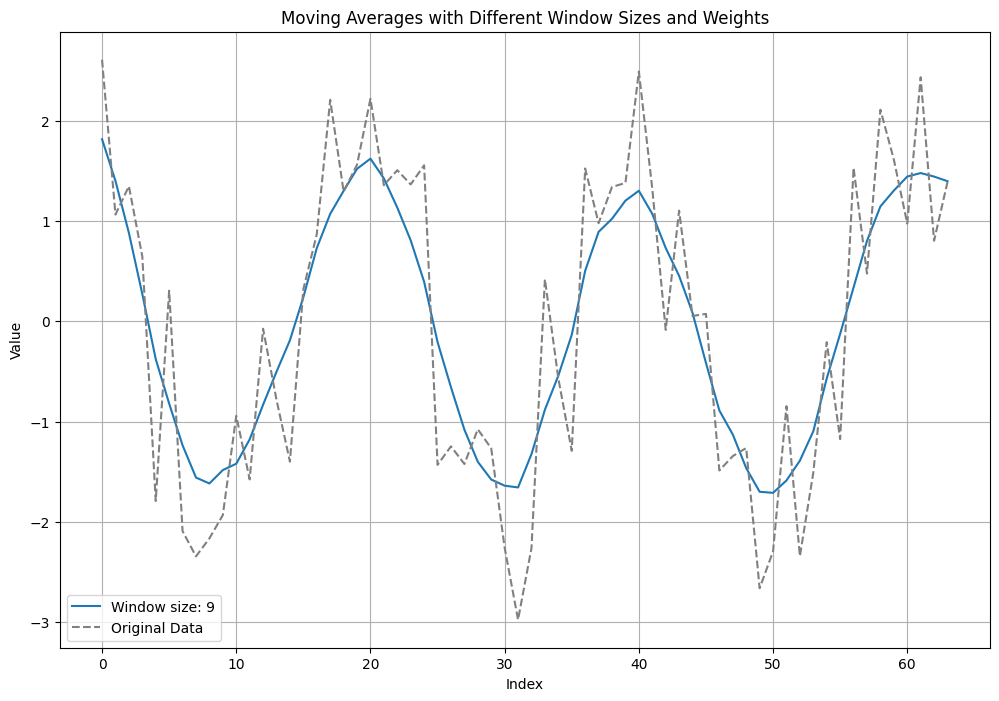

64
Ema <class 'float'>
64
DEMA <class 'tuple'>


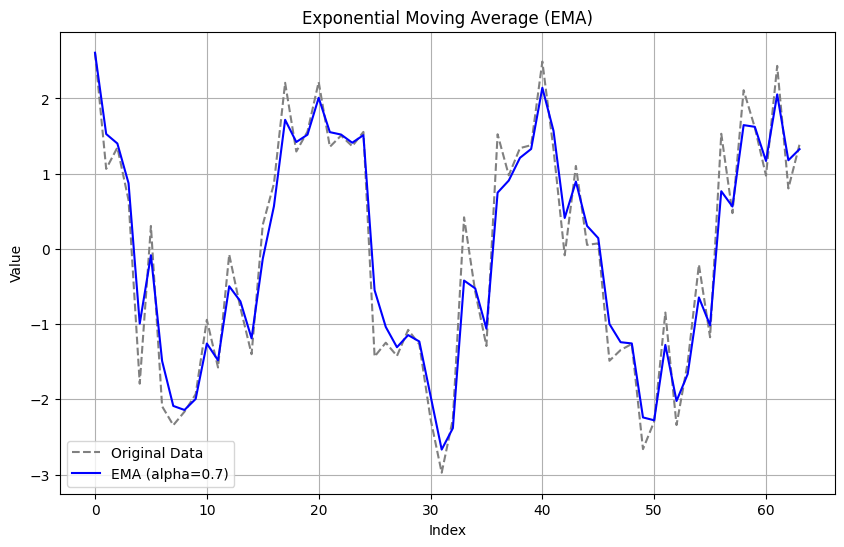

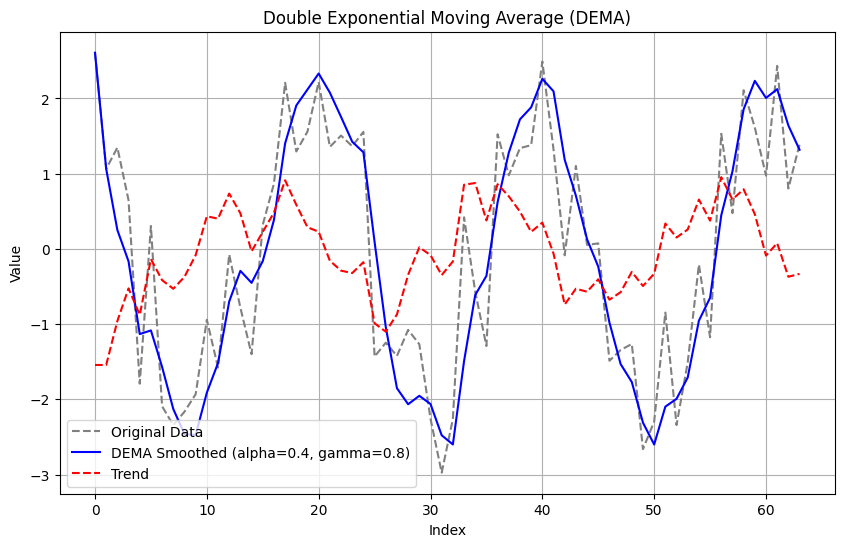

64
{'Non_Weighted': 3.0799753026724006}
1.41 1.47
{'Non_Weighted': 3.0799753026724006, 'Weighted': 1.9219721561762702}
1.41 1.47
{'Non_Weighted': 3.0799753026724006, 'Weighted': 1.9219721561762702, 'Ema': 0.41164025208740035}
1.41 1.47
{'Non_Weighted': 3.0799753026724006, 'Weighted': 1.9219721561762702, 'Ema': 0.41164025208740035, 'DEMA': 1.281972410806511}
1.41 1.47
Для алгоритма сглаживания Non_Weighted
Наличествует положительная автокорреляция первого порядка
Для алгоритма сглаживания Weighted
Наличествует отрицательная автокорреляция первого порядка
Для алгоритма сглаживания Ema
Наличествует положительная автокорреляция первого порядка
Для алгоритма сглаживания DEMA
Наличествует положительная автокорреляция первого порядка


In [ ]:
Obj = Darwin_Uotson(data[0])